In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Reading Data

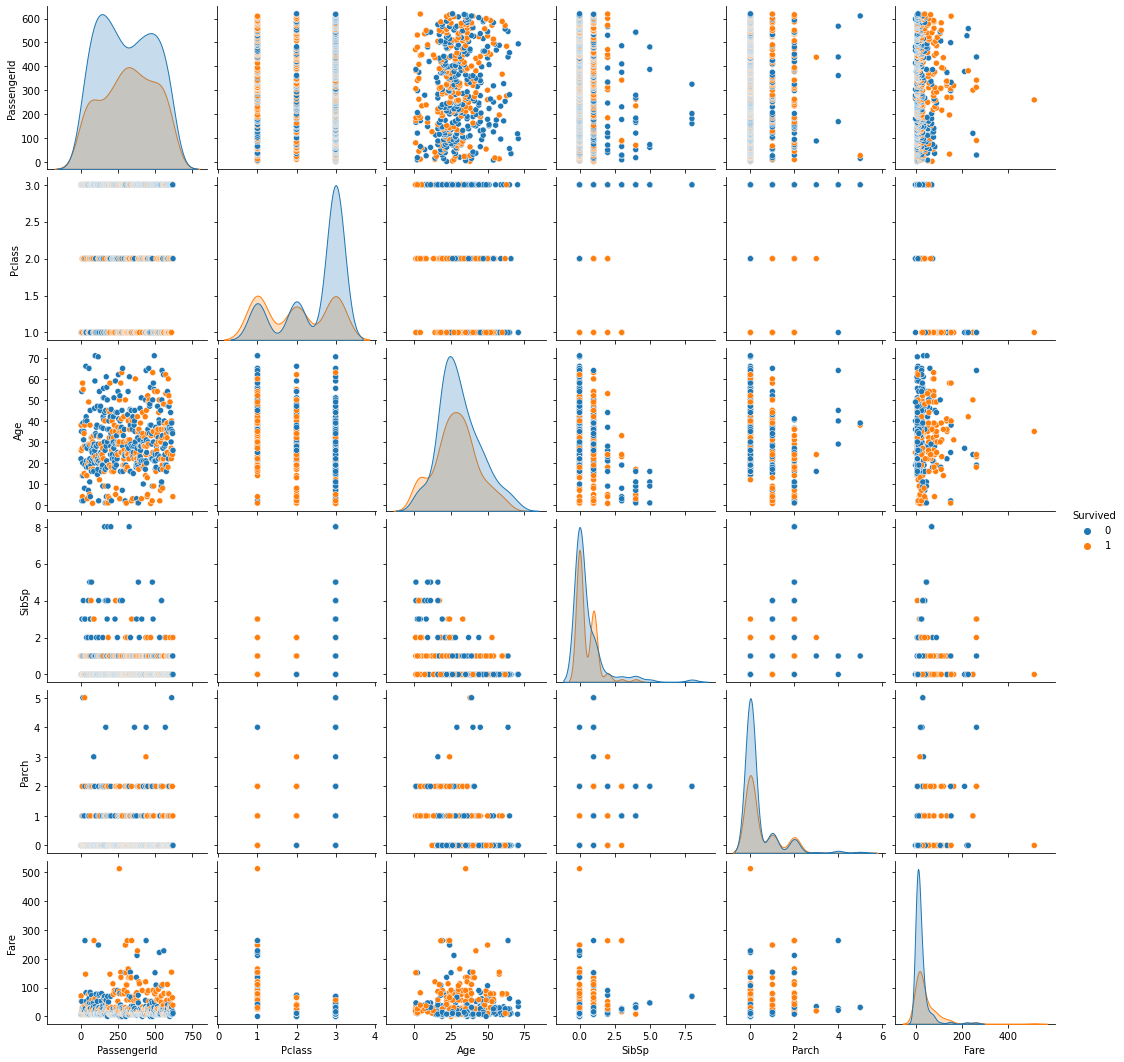

In [2]:

test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

# def swap_columns(df, c1, c2):
#     df['temp'] = df[c1]
#     df[c1] = df[c2]
#     df[c2] = df['temp']
#     df.drop(columns=['temp'], inplace=True)
    
# swap_columns(test, 'Survived', 'Fare')
# swap_columns(train, 'Survived', 'Fare')


sns.pairplot(train,hue="Survived")

# Preprocessing

In [3]:
#Filling empty cells with mean

test.fillna(test.mean(), inplace = True)
train.fillna(train.mean(), inplace = True)

from sklearn.preprocessing import LabelEncoder

#Assigining Male to 1 and female to 0

le = LabelEncoder()
test['Sex']=le.fit_transform(test['Sex'])
train['Sex']=le.fit_transform(train['Sex'])


# Decision Tree

In [4]:
#Entropy of a Single Column which is going for forking

def entropy(col):
    counts = np.unique(col,return_counts=True)
    ent = 0.0
    for ix in counts[1]:
        p = ix/col.shape[0]
        ent += (-1.0*p*np.log2(p))
    return ent


In [5]:
#Dividing the targeted Column

def divide_data(data, target_column, threshold):
    right = pd.DataFrame([], columns = data.columns)
    left = pd.DataFrame([], columns = data.columns)
    
    for i in range(data.shape[0]):
        value = data[target_column].loc[i]
        if value >= threshold:
            right = right.append(data.iloc[i])
        else:
            left = left.append(data.iloc[i])
            
    return right, left

In [6]:
#entrpy Gain after Dividing

def info_gain(data, target_column, threshold):
    
    right,left = divide_data(data, target_column, threshold)
    
    left_prob = float(left.shape[0])/data.shape[0]
    right_prob = float(right.shape[0])/data.shape[0]
    if left.shape[0] == 0 or right.shape[0] == 0:
        return -99999
    gain = entropy(data.Survived) - (left_prob * entropy(left.Survived) + right_prob*entropy(right.Survived))  
    return gain

In [13]:
#Class of Decision Tree for training and Predicting

class Decision_Tree:
    def __init__(self,depth=0,max_depth=4):
        self.left = None
        self.right = None
        self.target = None
        self.threshold = None
        self.depth = depth
        self.max_depth = max_depth
        self.value = None
    def train(self,data):
        features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
        gains = []  #Array for collecting Gain
        for i in features:
            gain = info_gain(data,i,data[i].mean())
            gains.append(gain)
            
        #Getting Target column and threshold from feature with maximum gain
        self.target = features[np.argmax(gains)]
        self.threshold = data[self.target].mean()
        
        #Dividing the data
        data_right,data_left = divide_data(data,self.target,self.threshold)
        data_right = data_right.reset_index(drop=True)
        data_left = data_left.reset_index(drop=True)
        if data_left.shape[0] == 0 or data_right.shape[0] == 0:  #tree ended
            if data.Survived.mean() >= 0.5:
                self.value = 1 
            else:
                self.value = 0 
            return
        if self.depth >= self.max_depth:   #depth crosses the maximum depth 
            if data.Survived.mean() >= 0.5:
                self.value = 1
            else:
                self.value = 0
            return
        
        #If not either of the above mentioned case, then recursive step
        self.left = Decision_Tree(self.depth+1,self.max_depth)
        self.left.train(data_left)
        self.right = Decision_Tree(self.depth+1,self.max_depth)
        self.right.train(data_right)
        if data.Survived.mean() >= 0.5:
            self.value = 1
        else:
            self.value = 0
        return
    
    #Precting the test dataset
    def predict(self,test):
        if test[self.target] > self.threshold:
            if self.right is None:
                return self.value
            return self.right.predict(test)
        if test[self.target] < self.threshold:
            if self.right is None:
                return self.value
            return self.right.predict(test)

In [14]:
model = Decision_Tree()

In [15]:
model.train(train)

y_pred = []
for i in range(test.shape[0]):
    y_pred.append(model.predict(test.loc[i]))

np.mean(y_pred == test['Survived'])

0.6383763837638377